# DICOM画像の扱い

## pydicom
画像を1スライスだけ読み込むときや、画像のメタデータ(患者IDなど)を見たいときなどはpydicomを使う

### 読み込みと表示
とりあえず1枚読み込んで表示してみる

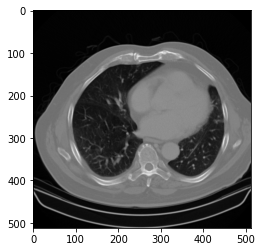

In [1]:
from pathlib import Path
import numpy as np
import pydicom
import matplotlib.pyplot as plt

dcm_dir = Path('Data/dicom/LIDC/LIDC-IDRI-0957/01-01-2000-82159/5434-CAP  5.0  B30s-51463')
dcm = pydicom.dcmread(dcm_dir / '000017.dcm')
plt.imshow(dcm.pixel_array, cmap='gray')

### DICOMに保存されている画素値をCT値(Hounsfield Unit)に変換する
`HU = slope * pixel_value + intercept`

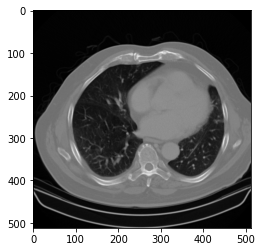

In [2]:
image = dcm.RescaleSlope * dcm.pixel_array + dcm.RescaleIntercept
plt.imshow(image, cmap='gray')

### Window設定
肺野Window(中心=-700、幅=1500)に変換する

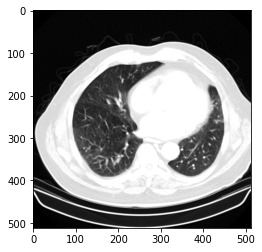

In [3]:
def window_image(x, wlww=[-700, 1500]):
    wl, ww = wlww
    minmax = (wl-ww/2, wl+ww/2)
    x = np.clip(x, minmax[0], minmax[1]).astype(np.float)
    return np.round(255*(x - minmax[0])/(minmax[1]-minmax[0])).astype(np.uint8)

plt.imshow(window_image(image, [-700, 1500]), cmap='gray')

縦隔条件

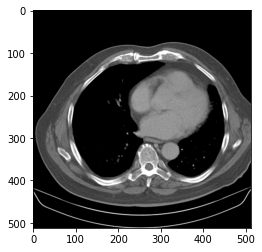

In [4]:
plt.imshow(window_image(image, [70, 700]), cmap='gray')

## SimpleITK
ボリューム全体を読み込むときや、DICOMを別のフォーマットに変換するときにはSimpleITKを用いる

### 読み込みと表示

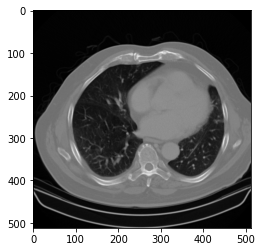

In [5]:
import SimpleITK as sitk
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(str(dcm_dir))
reader.SetFileNames(dicom_names)

sitk_volume = reader.Execute()
volume = sitk.GetArrayFromImage(sitk_volume)
plt.imshow(volume[len(volume)//2], cmap='gray')

### コロナル断面で表示

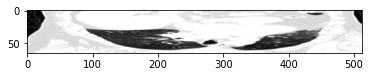

In [6]:
coronal = volume[:, volume.shape[1]//2]
coronal = window_image(coronal, [-700, 1500])
plt.imshow(coronal, cmap='gray')

#### 画像の向きとボクセルサイズを考慮する

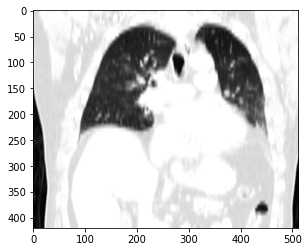

In [7]:
from PIL import Image
def resize(img, aspect, resample=Image.BILINEAR):
    pil_img = Image.fromarray(img)
    size = np.array(pil_img.size)
    if aspect >= 1:
        size[1] *= aspect
    else:
        size[0] /= aspect
    return pil_img.resize(size=size, resample=resample)

coronal = np.flip(coronal, axis=0)
spacing = sitk_volume.GetSpacing()[::-1]
plt.imshow(resize(coronal, spacing[0]/spacing[1]), cmap='gray')

### 別フォーマットで保存
DICOMを毎回読み込むのは面倒なので別のフォーマットに変換する。
MHD, NifTi, NRRDなどがよく使われる。

[フォーマット一覧](https://insightsoftwareconsortium.github.io/itk-js/docs/image_formats.html)

保存した画像は下記viewer等で閲覧できる。

- [itksnap](http://www.itksnap.org/pmwiki/pmwiki.php)
- [3D slicer](https://www.slicer.org)
- [MITK](https://www.mitk.org/wiki/The_Medical_Imaging_Interaction_Toolkit_(MITK))


In [8]:
import os
volume_filename = 'volume.mha'
sitk.WriteImage(sitk_volume, volume_filename, useCompression=True)
print('filesize: {:g} MB'.format(os.stat(volume_filename).st_size / 1024 / 1024))

filesize: 19.2435 MB


### 保存した画像を読み込む

In [9]:
image = sitk.ReadImage(volume_filename)
image.GetSize()

(512, 512, 65)